In [1]:
import pandas as pd 
from sklearn.model_selection import RandomizedSearchCV

In [2]:
import  numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
import joblib
import json

from datetime import datetime
from sklearn.metrics import mean_absolute_error


In [6]:
X=pd.read_csv('X_final.csv')
y=pd.read_csv('y.csv')

In [7]:
'''Creates training and testing datasets for unbiased evaluation.'''
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
'''Tunes Random Forest hyperparameters for optimal performance.'''
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    n_iter=10,
    cv=3,
    scoring='r2',
    n_jobs=-1
)

search.fit(X_train, y_train)


C:\Users\hp\anaconda3\envs\udemy_KNML\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestR...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'max_depth': [None, 10, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 200, ...]}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'r2'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default

In [9]:
'''Retrieves the best tuned model.'''
final_model = search.best_estimator_


In [10]:
final_model

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [11]:
'''Evaluate the final optimised model'''
y_pred  = final_model.predict(X_test)

rmse  = np.sqrt(mean_squared_error(y_test, y_pred ))
r2  = r2_score(y_test, y_pred )
mae = mean_absolute_error(y_test, y_pred )

print(f"RMSE: {rmse :.4f}")
print(f"R2:   {r2 :.4f}")
print(f"MAE:  {mae:.4f}")

RMSE: 0.3207
R2:   0.6885
MAE:  0.1302


In [12]:
'''Identify the features that most influence the rating  prediction '''
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': final_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance.head(15)


,Feature,Importance
2,votes,0.376655
3,approx_cost(for two people),0.140891
5,cuisines_count,0.065766
4,pop_cuisines_count,0.062591
13,location_Other,0.020393
52,rest_type_first_Quick Bites,0.019598
0,online_order,0.017480
32,listed_in(city)_Other,0.016602
6,location_BTM,0.014959
42,rest_type_first_Dessert Parlor,0.014370


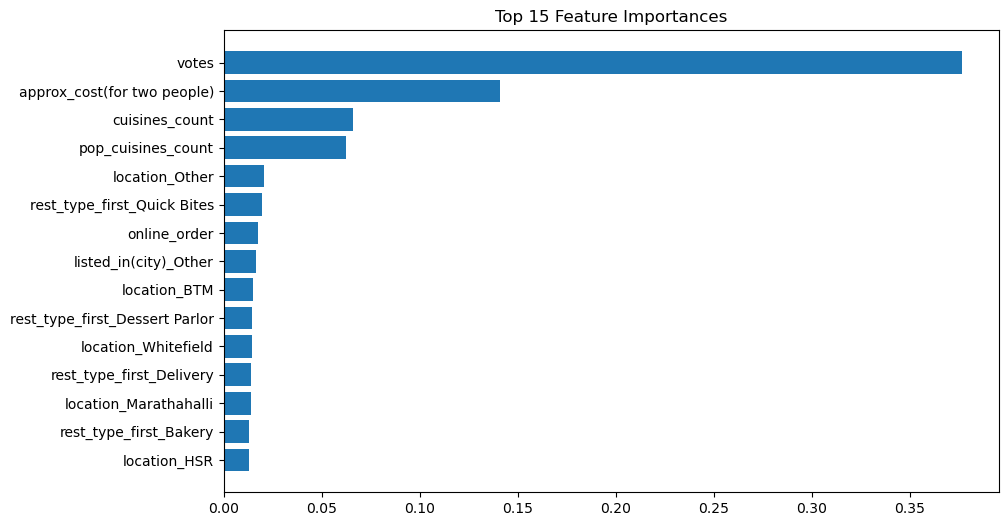

In [13]:
'''Visualizes top contributing features.'''
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(feature_importance['Feature'][:15],
         feature_importance['Importance'][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances")
plt.show()


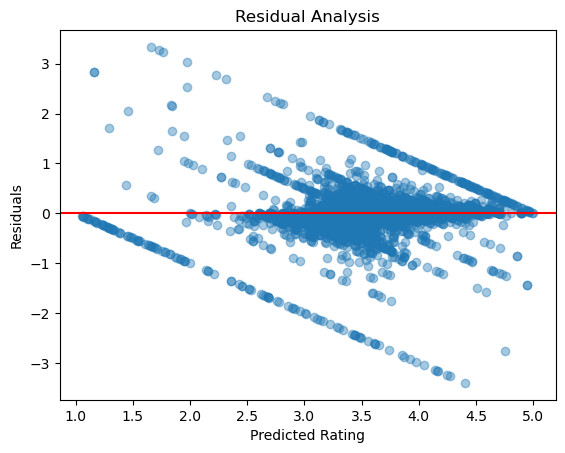

In [14]:
'''checks prediction errors and model bias'''
y_pred  = pd.Series(y_pred , index=y_test.index)
y_test=y_test.values.ravel()
'''WHY .ravel() / .squeeze() IS REQUIRED
Object	Shape
Series	(n,)
DataFrame	(n,1)

Regression math & plots require 1D vectors.

This is why sklearn internally works but matplotlib breaks.


The error occurred because y_test was a DataFrame with shape (n,1) while predictions were 1D. Matplotlib requires equal 1D arrays, so I flattened the target using .ravel().'''
residuals = y_test - y_pred 

plt.scatter(x=y_pred .values, y=residuals.values, alpha=0.4)
plt.axhline(0, color='red')
plt.xlabel("Predicted Rating")
plt.ylabel("Residuals")
plt.title("Residual Analysis")
plt.show()


In [15]:
print(type(y_test))
print(y_test.shape)

print(type(y_pred ))
print(y_pred .shape)


<class 'numpy.ndarray'>
(8825,)
<class 'pandas.core.series.Series'>
(8825,)


In [17]:
model_params = final_model.get_params()


In [18]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

model_name = f"zomato_rating_model_rmse_{rmse:.3f}_{timestamp}.joblib"
meta_name = f"zomato_rating_model_metadata_{timestamp}.json"

print(model_name)


zomato_rating_model_rmse_0.321_20251229_0230.joblib


In [19]:
joblib.dump(final_model, model_name)
print("Model saved successfully")


Model saved successfully


In [20]:
metadata = {
    "model_type": type(final_model).__name__,
    "rmse": rmse,
    "r2_score": r2,
    "mae": mae,
    "hyperparameters": model_params,
    "n_features": X_test.shape[1],
    "features": list(X_test.columns),
    "trained_on": timestamp
}


In [21]:
with open(meta_name, "w") as f:
    json.dump(metadata, f, indent=4)

print("Metadata saved successfully")


Metadata saved successfully


In [22]:
'''with open(meta_name, "w") as f:
    json.dump(metadata, f, indent=4)

print("Metadata saved successfully")
'''

'with open(meta_name, "w") as f:\n    json.dump(metadata, f, indent=4)\n\nprint("Metadata saved successfully")\n'